# Booking

In this example, we will use the 'Expedia' dataset to predict, based on users' site activity, a user is likely to make a booking. You can download the Jupyter Notebook of the study <a href="booking.ipynb">here</a> and the the dataset <a href="https://www.kaggle.com/c/expedia-hotel-recommendations/data">here</a>.

<ul class="ul_content">
    <li><b>cnt: </b>Number of similar events in the context of the same user session.</li>
    <li><b>user_location_city: </b>The ID of the city in which the customer is located.</li>
    <li><b>is_package: </b>1 if the click/booking was generated as a part of a package (i.e. combined with a flight), 0 otherwise.</li>
    <li><b>user_id: </b>ID of the user</li>
    <li><b>srch_children_cnt: </b>The number of (extra occupancy) children specified in the hotel room.</li>
    <li><b>channel: </b>marketing ID of a marketing channel.</li>
    <li><b>hotel_cluster: </b>ID of a hotel cluster.</li>
    <li><b>srch_destination_id: </b>ID of the destination where the hotel search was performed.</li>
    <li><b>is_mobile: </b>1 if the user is on a mobile device, 0 otherwise.</li>
    <li><b>srch_adults_cnt: </b>The number of adults specified in the hotel room.</li>
    <li><b>user_location_country: </b>The ID of the country in which the customer is located.</li>
    <li><b>srch_destination_type_id: </b>ID of the destination where the hotel search was performed.</li>
    <li><b>srch_rm_cnt: </b>The number of hotel rooms specified in the search.</li>
    <li><b>posa_continent: </b>ID of the continent associated with the site_name.</li>
    <li><b>srch_ci: </b>Check-in date.</li>
    <li><b>user_location_region: </b>The ID of the region in which the customer is located.</li>
    <li><b>hotel_country: </b>Hotel's country.</li>
    <li><b>srch_co: </b>Check-out date.</li>
    <li><b>is_booking: </b>1 if a booking, 0 if a click.</li>
    <li><b>orig_destination_distance: </b>Physical distance between a hotel and a customer at the time of search. A null means the distance could not be calculated.</li>
    <li><b>hotel_continent: </b>Hotel continent.</li>
    <li><b>site_name: </b>ID of the Expedia point of sale (i.e. Expedia.com, Expedia.co.uk, Expedia.co.jp, ...).</li>
</ul>

We will follow the data science cycle (Data Exploration - Data Preparation - Data Modeling - Model Evaluation - Model Deployment) to solve this problem.

## Initialization

Let's create a Virtual DataFrame of the dataset.

In [9]:
from verticapy.connections.connect import *
new_auto_connection({"host": "192.168.56.201", 
                     "port": "5433", 
                     "database": "dw", 
                     "password": "vertica_4U", 
                     "user": "dbadmin"},
                    name = "VerticaDSN")
change_auto_connection("VerticaDSN")

,📅date_timeTimestamp,123site_nameInt,123posa_continentInt,123user_location_countryInt,123user_location_regionInt,123user_location_cityInt,"123orig_destination_distanceNumeric(11,5)",123user_idInt,123is_mobileInt,123is_packageInt,123channelInt,📅srch_ciDate,📅srch_coDate,123srch_adults_cntInt,123srch_children_cntInt,123srch_rm_cntInt,123srch_destination_idInt,123srch_destination_type_idInt,123is_bookingInt,123cntInt,123hotel_continentInt,123hotel_countryInt,123hotel_marketInt,123hotel_clusterInt
1,2013-01-07 00:00:06,11,3,205,155,14703,795.7298,1128575,0,0,9,2013-01-19,2013-01-22,1,0,1,25064,6,0,1,2,50,1230,91
2,2013-01-07 00:00:17,37,1,69,761,41949,[null],1018895,0,0,0,2013-09-08,2013-09-10,2,0,1,27215,6,0,2,2,50,645,59
3,2013-01-07 00:00:23,37,1,69,761,41949,[null],1080476,0,1,9,2013-05-29,2013-06-05,2,0,1,7635,3,0,1,2,50,675,10
4,2013-01-07 00:00:29,24,2,3,49,19105,[null],1174819,0,0,9,2013-04-25,2013-04-28,2,0,1,14908,1,0,1,3,88,1032,75
5,2013-01-07 00:00:39,2,3,119,0,27731,[null],519086,0,0,9,2013-01-09,2013-01-11,1,0,1,1510,3,0,3,3,99,1043,82

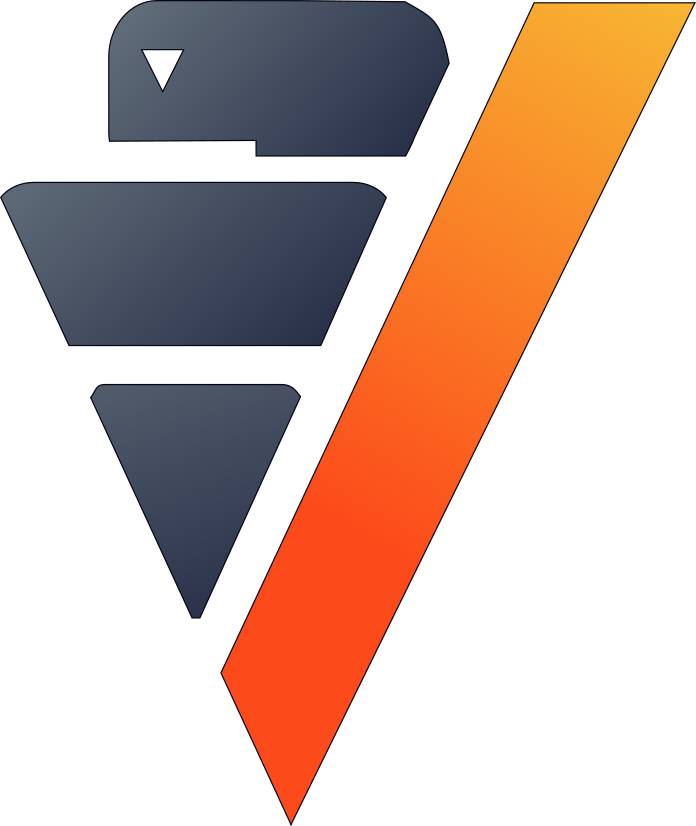

In [10]:
from verticapy import *
import verticapy.stats as st
expedia = vDataFrame('expedia')
expedia.head(5)

## Data Exploration and Preparation

Sessionization is the process of gathering clicks for a certain period of time. We usually consider that after 30 minutes of inactivity, the user session ends (date_time - lag(date_time) > 30 minutes). For these kinds of use cases, aggregating sessions with meaningful statistics is the key for making accurate predictions.

,📅date_timeTimestamp,123site_nameInt,123posa_continentInt,123user_location_countryInt,123user_location_regionInt,123user_location_cityInt,"123orig_destination_distanceNumeric(11,5)",123user_idInt,123is_mobileInt,123is_packageInt,123channelInt,📅srch_ciDate,📅srch_coDate,123srch_adults_cntInt,123srch_children_cntInt,123srch_rm_cntInt,123srch_destination_idInt,123srch_destination_type_idInt,123is_bookingInt,123cntInt,123hotel_continentInt,123hotel_countryInt,123hotel_marketInt,123hotel_clusterInt,123session_idInteger
1,2014-12-03 11:30:21,2,3,66,174,42538,343.7968,0,1,0,2,2014-12-29,2014-12-30,2,1,1,8279,1,0,1,2,50,1230,56,0
2,2014-04-25 16:14:28,2,3,66,174,37449,5405.4889,1,1,0,2,2014-11-07,2014-11-09,3,1,1,62881,4,0,1,4,98,2052,20,0
3,2014-01-27 12:56:00,2,3,66,311,25671,[null],2,0,1,9,2014-04-08,2014-04-12,2,0,1,11621,1,0,2,2,50,703,96,0
4,2014-01-27 13:18:43,2,3,66,311,25671,[null],2,0,1,9,2014-04-08,2014-04-12,2,0,1,11621,1,0,1,2,50,703,94,0
5,2014-01-27 13:22:39,2,3,66,311,25671,[null],2,0,1,9,2014-04-08,2014-04-12,2,0,1,11621,1,0,1,2,50,703,21,0
6,2014-01-27 13:54:07,2,3,66,311,25671,[null],2,0,1,9,2014-04-08,2014-04-11,2,0,1,11621,1,0,2,2,50,703,94,1
7,2014-01-28 12:27:47,2,3,66,311,25671,[null],2,0,1,9,2014-04-08,2014-04-11,2,0,1,12008,1,0,1,2,50,686,41,2
8,2014-01-28 12:28:31,2,3,66,311,25671,[null],2,0,1,9,2014-04-08,2014-04-11,2,0,1,12008,1,0,1,2,50,686,73,2
9,2014-01-28 12:31:18,2,3,66,311,25671,[null],2,0,1,9,2014-04-08,2014-04-11,2,0,1,12008,1,0,1,2,50,686,68,2
10,2014-07-31 07:10:39,2,3,66,321,51642,1432.9656,3,0,0,9,2015-02-07,2015-02-10,3,2,2,28586,6,0,1,2,50,705,5,0

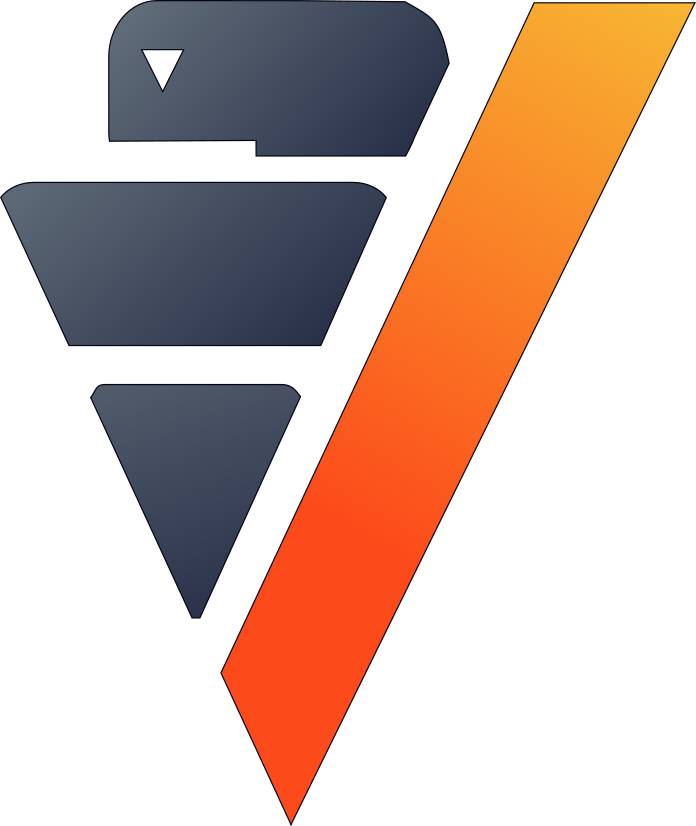

In [11]:
expedia.sessionize(ts = "date_time", 
                   by = ["user_id"], 
                   session_threshold = "30 minutes", 
                   name = "session_id")

By using the method 'sessionize', we are able to create variable 'session_id', which we can use to aggregate the data.

The duration of the trip should also influence/be indicative of the user's behavior on the site.

In [12]:
expedia["trip_duration"] = expedia["srch_co"] - expedia["srch_ci"]

If a user looks at the same hotel several times, then it might mean that they're looking to book that hotel during the session.

,📅date_timeTimestamp,123site_nameInt,123posa_continentInt,123user_location_countryInt,123user_location_regionInt,123user_location_cityInt,"123orig_destination_distanceNumeric(11,5)",123user_idInt,123is_mobileInt,123is_packageInt,123channelInt,📅srch_ciDate,📅srch_coDate,123srch_adults_cntInt,123srch_children_cntInt,123srch_rm_cntInt,123srch_destination_idInt,123srch_destination_type_idInt,123is_bookingInt,123cntInt,123hotel_continentInt,123hotel_countryInt,123hotel_marketInt,123hotel_clusterInt,123session_idInteger,123trip_durationInteger,123mode_hotel_clusterInteger,123mode_hotel_cluster_countInteger
1,2014-12-03 11:30:21,2,3,66,174,42538,343.7968,0,1,0,2,2014-12-29,2014-12-30,2,1,1,8279,1,0,1,2,50,1230,56,0,1,56,1
2,2014-04-25 16:14:28,2,3,66,174,37449,5405.4889,1,1,0,2,2014-11-07,2014-11-09,3,1,1,62881,4,0,1,4,98,2052,20,0,2,20,1
3,2014-01-27 12:56:00,2,3,66,311,25671,[null],2,0,1,9,2014-04-08,2014-04-12,2,0,1,11621,1,0,2,2,50,703,96,0,4,96,1
4,2014-01-27 13:18:43,2,3,66,311,25671,[null],2,0,1,9,2014-04-08,2014-04-12,2,0,1,11621,1,0,1,2,50,703,94,0,4,96,1
5,2014-01-27 13:22:39,2,3,66,311,25671,[null],2,0,1,9,2014-04-08,2014-04-12,2,0,1,11621,1,0,1,2,50,703,21,0,4,96,1
6,2014-01-27 13:54:07,2,3,66,311,25671,[null],2,0,1,9,2014-04-08,2014-04-11,2,0,1,11621,1,0,2,2,50,703,94,1,3,94,1
7,2014-01-28 12:28:31,2,3,66,311,25671,[null],2,0,1,9,2014-04-08,2014-04-11,2,0,1,12008,1,0,1,2,50,686,73,2,3,73,1
8,2014-01-28 12:31:18,2,3,66,311,25671,[null],2,0,1,9,2014-04-08,2014-04-11,2,0,1,12008,1,0,1,2,50,686,68,2,3,73,1
9,2014-01-28 12:27:47,2,3,66,311,25671,[null],2,0,1,9,2014-04-08,2014-04-11,2,0,1,12008,1,0,1,2,50,686,41,2,3,73,1
10,2014-07-31 07:10:39,2,3,66,321,51642,1432.9656,3,0,0,9,2015-02-07,2015-02-10,3,2,2,28586,6,0,1,2,50,705,5,0,3,5,1

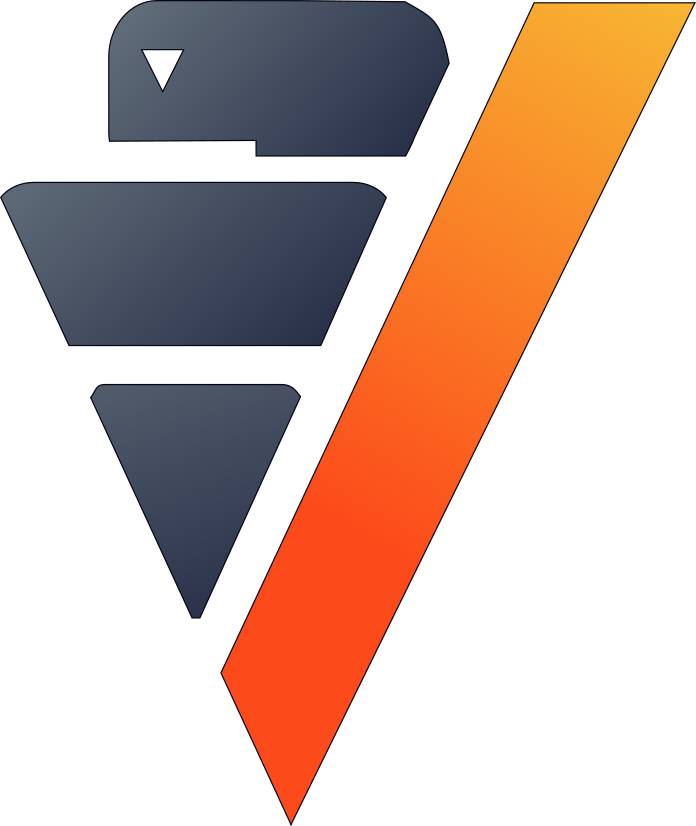

In [13]:
expedia.analytic('mode', 
                 column = "hotel_cluster", 
                 by = ["user_id",
                       "session_id"], 
                 name = "mode_hotel_cluster",
                 add_count = True)

We can now aggregate the session to get useful statistics.
<ul class="ul_content">
    <li><b>end_session_date_time :</b> Date and time when the session ends.</li>
    <li><b>session_duration :</b> Session duration.</li>
    <li><b>is_booking :</b> 1 if the user booked during the session, 0 otherwise.</li>
    <li><b>trip_duration :</b> Trip duration.</li>
    <li><b>orig_destination_distance :</b> Average of the physical distances between the hotels and the customer.</li>
    <li><b>srch_family_cnt :</b> The number of people specified in the hotel room.</li>
</ul>

In [14]:
expedia = expedia.groupby(
      columns = ["user_id",
                 "session_id", 
                 "mode_hotel_cluster_count"], 
      expr = [st.max(expedia["date_time"])._as("end_session_date_time"),
              ((st.max(expedia["date_time"]) - st.min(expedia["date_time"])) / st.interval("1 second"))._as(
                  "session_duration"),
              st.max(expedia["is_booking"])._as("is_booking"),
              st.avg(expedia["trip_duration"])._as("trip_duration"),
              st.avg(expedia["orig_destination_distance"])._as("avg_distance"),
              st.sum(expedia["cnt"])._as("nb_click_session"),
              st.median(expedia["srch_children_cnt"] + expedia["srch_adults_cnt"])._as("srch_family_cnt")])

Let's look at the missing values.

,count,percent
"""user_id""",6090944.0,100.0
"""session_id""",6090944.0,100.0
"""mode_hotel_cluster_count""",6090944.0,100.0
"""end_session_date_time""",6090944.0,100.0
"""session_duration""",6090944.0,100.0
"""is_booking""",6090944.0,100.0
"""nb_click_session""",6090944.0,100.0
"""srch_family_cnt""",6090944.0,100.0
"""trip_duration""",6083093.0,99.871
"""avg_distance""",3939819.0,64.683

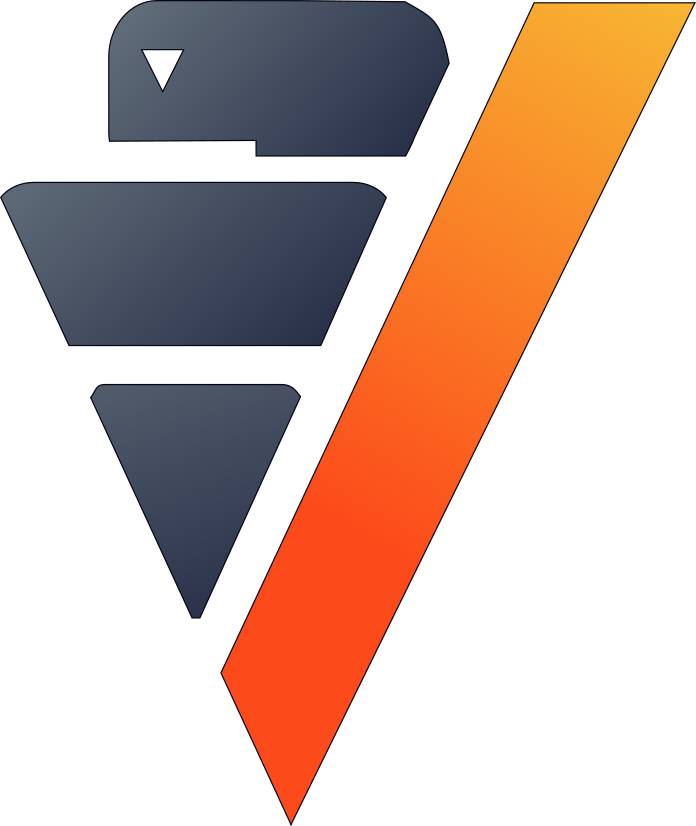

In [15]:
expedia.count()

Let's impute the missing values of avg_distance and trip_duration.

2151125 elements were filled.
7851 elements were filled.


,123user_idInt100%,123session_idInt100%,123mode_hotel_cluster_countInt100%,📅end_session_date_timeTimestamp100%,123session_durationFloat100%,123is_bookingInt100%,123trip_durationFloat100%,123avg_distanceFloat100%,123nb_click_sessionInt100%,123srch_family_cntFloat100%
1,0,0,1,2014-12-03 11:30:21,0.0,0,1.0,343.7968,1,3.0
2,1,0,1,2014-04-25 16:14:28,0.0,0,2.0,5405.4889,1,4.0
3,2,0,1,2014-01-27 13:22:39,1599.0,0,4.0,1898.69344786096,4,2.0
4,2,1,1,2014-01-27 13:54:07,0.0,0,3.0,1898.69344786096,2,2.0
5,2,2,1,2014-01-28 12:31:18,211.0,0,3.0,1898.69344786096,3,2.0
6,3,0,1,2014-07-31 07:10:39,0.0,0,3.0,1432.9656,1,5.0
7,3,1,1,2014-09-08 09:56:21,0.0,0,1.0,142.7467,1,2.0
8,3,2,1,2014-09-09 10:49:48,0.0,0,1.0,143.2998,1,4.0
9,4,0,1,2014-08-29 16:58:41,0.0,0,4.0,1318.1384,1,2.0
10,5,0,1,2014-01-26 23:56:46,0.0,0,4.0,960.42,1,2.0

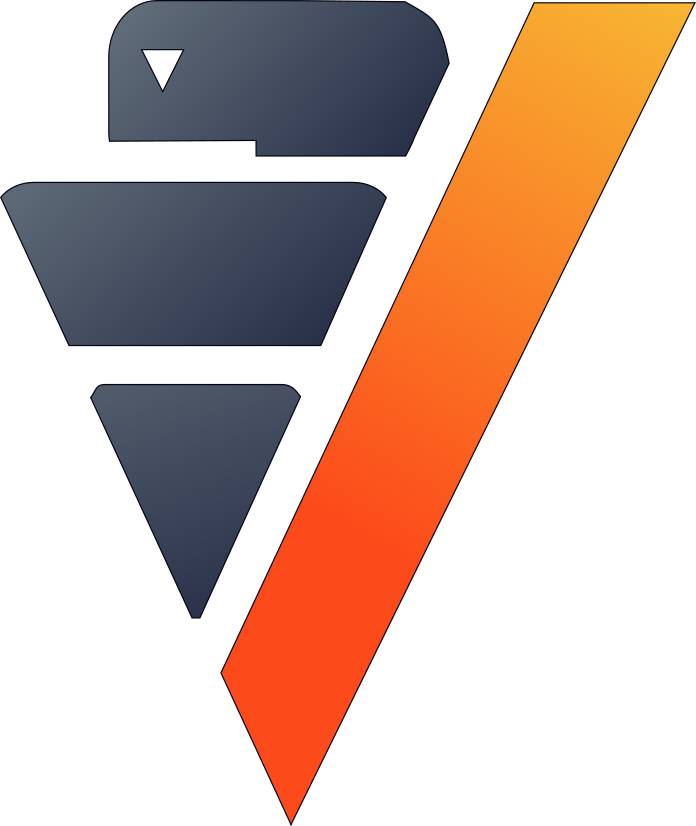

In [16]:
expedia["avg_distance"].fillna(method = "avg")
expedia["trip_duration"].fillna(method = "avg")

We can then look at the link between the variables. We will use Spearman's rank correleation coefficient to get all the monotonic relationships.

,"""user_id""","""session_id""","""mode_hotel_cluster_count""","""session_duration""","""is_booking""","""trip_duration""","""avg_distance""","""nb_click_session""","""srch_family_cnt"""
"""user_id""",1.0,0.0114013477549866,0.000204416489547985,-0.00109207878549565,0.00208338198296553,-0.00176391742596789,0.00737723950130264,-0.00112633190862467,-0.00218226955558142
"""session_id""",0.0114013477549866,1.0,-0.00034141195067768,0.00102277772426312,-0.0288605827097281,0.0175104436403534,0.0447258555598767,-0.0276810773578715,-0.0175886772687986
"""mode_hotel_cluster_count""",0.000204416489547985,-0.00034141195067768,1.0,0.545723873230062,0.221630004736907,0.0176063939264056,0.0118846314513952,0.437788821254541,0.037328142210674
"""session_duration""",-0.00109207878549565,0.00102277772426312,0.545723873230062,1.0,0.101153248326122,0.0403518274957873,0.0288146798368531,0.73157413898997,0.0588735955163147
"""is_booking""",0.00208338198296553,-0.0288605827097281,0.221630004736907,0.101153248326122,1.0,-0.140323909114311,-0.0436445467578453,-0.0297751127139699,-0.0498507483438938
"""trip_duration""",-0.00176391742596789,0.0175104436403534,0.0176063939264056,0.0403518274957873,-0.140323909114311,1.0,0.27128595519931,0.0766621794402464,0.0609358386404794
"""avg_distance""",0.00737723950130264,0.0447258555598767,0.0118846314513952,0.0288146798368531,-0.0436445467578453,0.27128595519931,1.0,0.0388421489173438,-0.0262844786942181
"""nb_click_session""",-0.00112633190862467,-0.0276810773578715,0.437788821254541,0.73157413898997,-0.0297751127139699,0.0766621794402464,0.0388421489173438,1.0,0.0698249177824453
"""srch_family_cnt""",-0.00218226955558142,-0.0175886772687986,0.037328142210674,0.0588735955163147,-0.0498507483438938,0.0609358386404794,-0.0262844786942181,0.0698249177824453,1.0

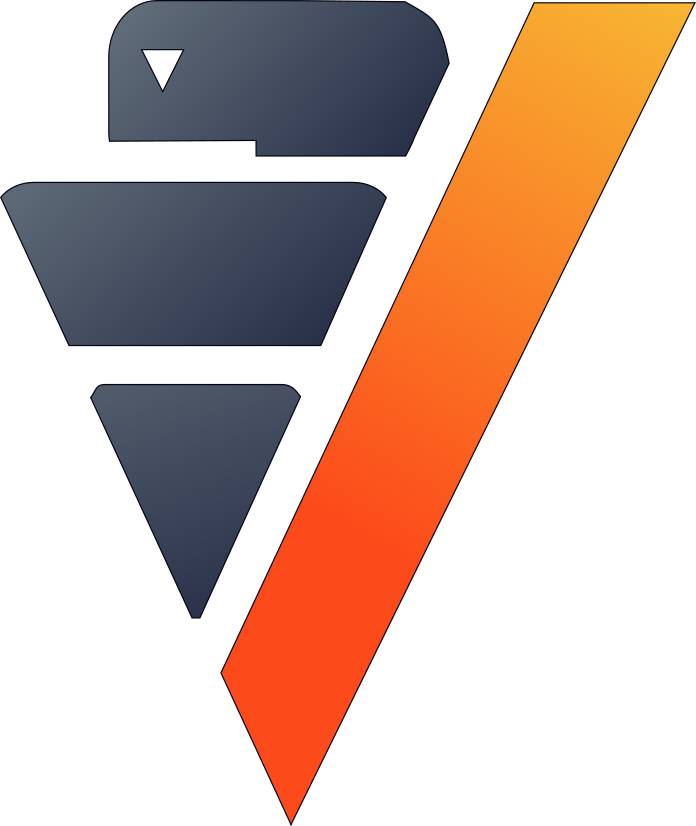

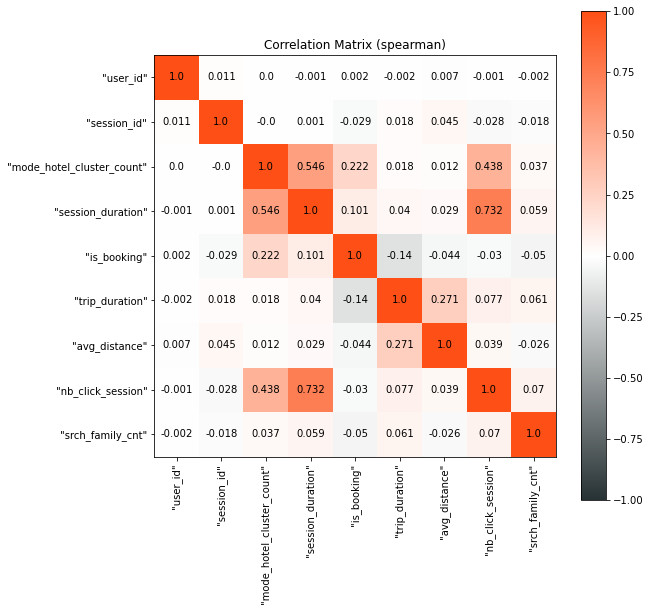

In [17]:
%matplotlib inline
expedia.corr(method = "spearman")

We can see huge links between some of the variables (mode_hotel_cluster_count & session_duration) and our response variable (is_booking). We can try to use a logistic regression, which will work well because the response and predictors have a monotonic relationship.

## Machine Learning

In [18]:
from verticapy.utilities import *
create_verticapy_schema()

Let's create our model.

In [19]:
from verticapy.learn.linear_model import LogisticRegression
model_logit = LogisticRegression("expedia_logit", 
                                 max_iter = 1000, 
                                 solver = 'BFGS')
model_logit.drop()
model_logit.fit(expedia, 
                ["avg_distance", 
                 "session_duration",
                 "nb_click_session",
                 "mode_hotel_cluster_count",
                 "session_id",
                 "srch_family_cnt",
                 "trip_duration"], 
                 "is_booking")



details
       predictor        |coefficient|std_err | z_value  |p_value 
------------------------+-----------+--------+----------+--------
       Intercept        | -2.14817  | 0.00547|-392.89356| 0.00000
      avg_distance      | -0.00002  | 0.00000|-28.87209 | 0.00000
    session_duration    |  0.00076  | 0.00000|230.72213 | 0.00000
    nb_click_session    | -0.43201  | 0.00138|-312.53011| 0.00000
mode_hotel_cluster_count|  1.56344  | 0.00357|437.99092 | 0.00000
       session_id       | -0.00884  | 0.00015|-58.18247 | 0.00000
    srch_family_cnt     | -0.15778  | 0.00143|-109.96253| 0.00000
     trip_duration      | -0.19831  | 0.00079|-249.50363| 0.00000


regularization
type| lambda 
----+--------
none| 1.00000


call_string
logistic_reg('public.expedia_logit', '"public"._VERTICAPY_TEMPORARY_VIEW_dbadmin_876', '"is_booking"', '"avg_distance", "session_duration", "nb_click_session", "mode_hotel_cluster_count", "session_id", "srch_family_cnt", "trip_duration"'
USING PARAMETERS op

None of our coefficients are rejected (pvalue = 0). Let's look at their importance.

,importance,sign
trip_duration,56.79,-1
nb_click_session,28.33,-1
mode_hotel_cluster_count,10.81,1
session_duration,3.17,1
srch_family_cnt,0.63,-1
session_id,0.2,-1
avg_distance,0.07,-1

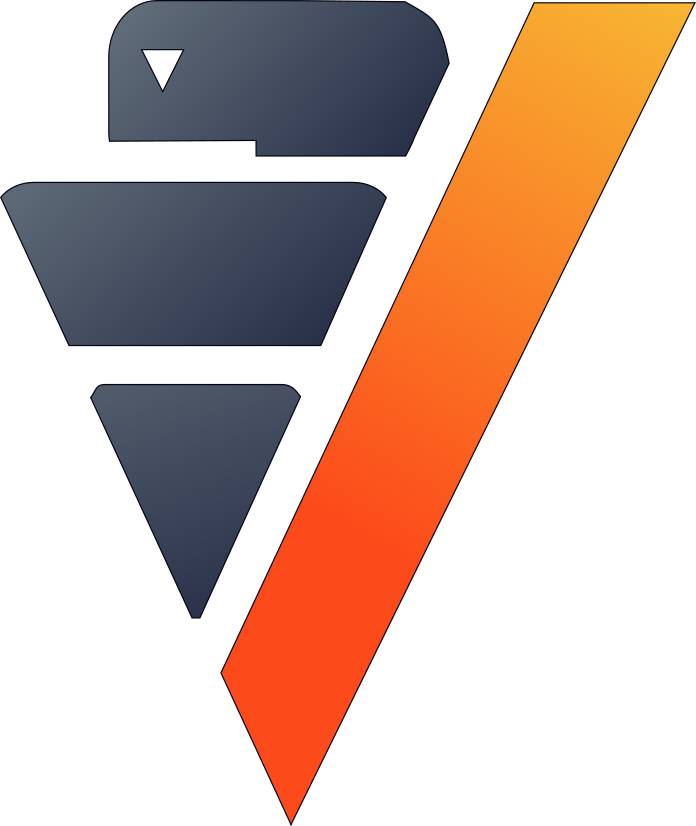

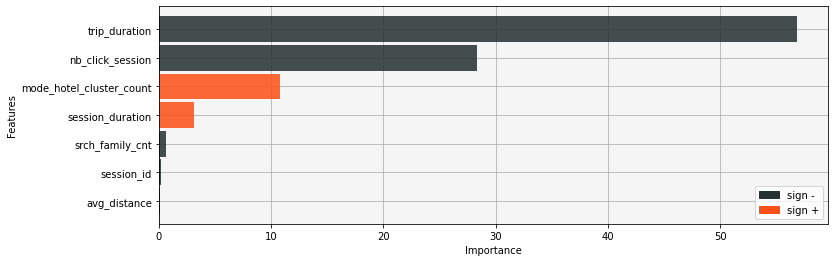

In [20]:
model_logit.features_importance()

It looks like there are two main predictors: mode_hotel_cluster_count and trip_duration. According to our model, users likely to make a booking during a particular session will tend to:

<ul class="ul_content">
    <li>look at the same hotel many times</li>
    <li>look for a shorter trip duration</li>
    <li>not click as much (spend more time at the same web page).</li>
</ul>

Let's add our prediction to the vDataFrame.

,123user_idInt,123session_idInt,123mode_hotel_cluster_countInt,📅end_session_date_timeTimestamp,123session_durationFloat,123is_bookingInt,123trip_durationFloat,123avg_distanceFloat,123nb_click_sessionInt,123srch_family_cntFloat,123booking_pred_logitFloat
1,0,0,1,2014-12-03 11:30:21,0.0,0,1.0,343.7968,1,3.0,0.154867311733555
2,1,0,1,2014-04-25 16:14:28,0.0,0,2.0,5405.4889,1,4.0,0.101672619142224
3,2,0,1,2014-01-27 13:22:39,1599.0,0,4.0,1898.69344786096,4,2.0,0.0956191903722245
4,2,1,1,2014-01-27 13:54:07,0.0,0,3.0,1898.69344786096,2,2.0,0.0820174277289845
5,2,2,1,2014-01-28 12:31:18,211.0,0,3.0,1898.69344786096,3,2.0,0.063277021140013
6,3,0,1,2014-07-31 07:10:39,0.0,0,3.0,1432.9656,1,5.0,0.0804558981298229
7,3,1,1,2014-09-08 09:56:21,0.0,0,1.0,142.7467,1,2.0,0.176100735922116
8,3,2,1,2014-09-09 10:49:48,0.0,0,1.0,143.2998,1,4.0,0.133841400981891
9,4,0,1,2014-08-29 16:58:41,0.0,0,4.0,1318.1384,1,2.0,0.10355987694389
10,5,0,1,2014-01-26 23:56:46,0.0,0,4.0,960.42,1,2.0,0.104387878773456

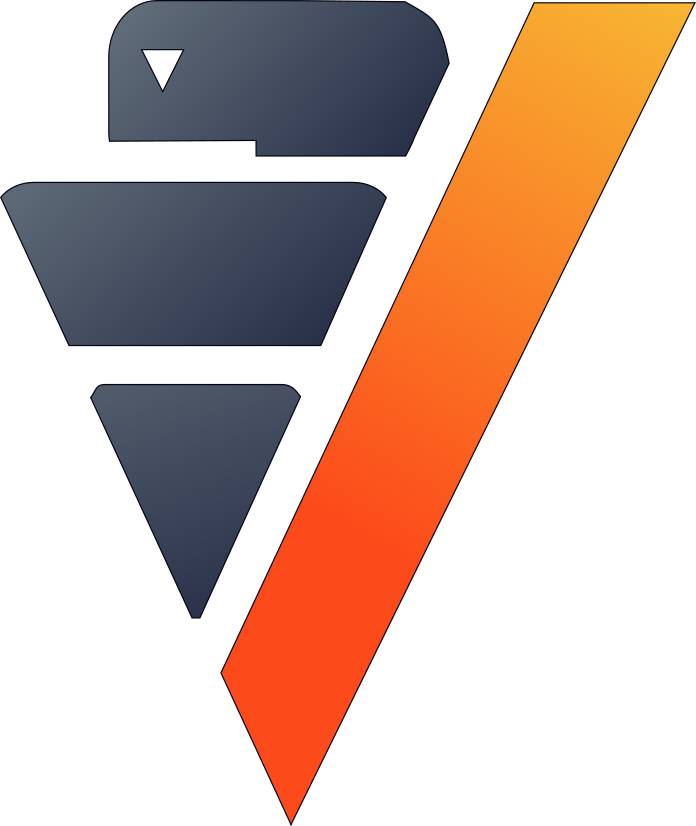

In [22]:
model_logit.predict(expedia, 
                    name = "booking_pred_logit", 
                    cutoff = -1.0)

We can analyze the following boxplot (prediction partitioned by is_booking). We can notice that the cutoff is around 0.22 as most of the positive predictions have a probability between 0.23 and 0.5 whereas most of the negative predictions are between 0.05 and 0.2.

<AxesSubplot:xlabel='"is_booking"', ylabel='"booking_pred_logit"'>

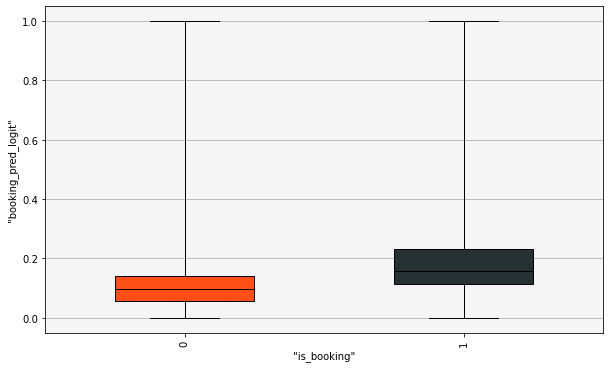

In [23]:
expedia["booking_pred_logit"].boxplot(by = "is_booking")

Let's confirm our hypothesis by computing the best cutoff.

In [24]:
model_logit.score(method = "best_cutoff")

0.124

Let's look at the efficiency of our model for this cutoff.

In [ ]:
model_logit.roc_curve()
model_logit.classification_report(cutoff = 0.124)

We're left with an excellent model. With this, we can predict whether a user will book a hotel during a specific session and make adjustments to our site accordingly. For example, to influence a user to make a booking, we could propose new hotels.

In [ ]:
from verticapy.utilities import *
drop_verticapy_schema()

## Conclusion

We've solved our problem in a Pandas-like way, all without ever loading data into memory!